In [195]:
from __future__ import print_function
import cv2
import lasagne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import theano
import theano.tensor as T
import time

from pylab import cm, imshow, show

In [196]:
import gzip

def load_dataset():
    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    X_train = load_mnist_images('mnist/train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('mnist/train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('mnist/t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('mnist/t10k-labels-idx1-ubyte.gz')

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [197]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [215]:
def dataset_test():
    image_num = np.random.randint(0, X_test.shape[0])
    image_array = X_test[image_num][0]
    image_2d = np.reshape(image_array, (28, 28))
    imshow(image_2d, cmap=cm.gray)
    

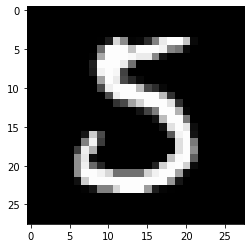

In [216]:
dataset_test()

In [217]:
def network_builder(input_var=None):
    input_layer = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)

    conv1_layer = lasagne.layers.Conv2DLayer(
            input_layer, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    maxpool1_layer = lasagne.layers.MaxPool2DLayer(conv1_layer, pool_size=(2, 2))

    conv2_layer = lasagne.layers.Conv2DLayer(
            maxpool1_layer, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
            
    maxpool2_layer = lasagne.layers.MaxPool2DLayer(conv2_layer, pool_size=(2, 2))

    dense_layer = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(maxpool2_layer, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    output_layer = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(dense_layer, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return output_layer

In [7]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [218]:
def main(model='cnn', batch_size=500, num_epochs=500):
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    print("Building model and compiling functions...")
    network = build_cnn(input_var)
    
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, 
                                                       target_var)
    loss = loss.mean()
    
    train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, 
                                                learning_rate=0.01, 
                                                momentum=0.9)


    test_prediction = lasagne.layers.get_output(network, 
                                                deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, 
                                                            target_var)
    test_loss = test_loss.mean()
    
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    train_fn = theano.function([input_var, target_var], [loss, train_acc], updates=updates)

    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    print("Starting training...")
    
    for epoch in range(num_epochs):
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            inputs, targets = batch
            err, acc = train_fn(inputs, targets)
            train_err += err
            train_acc += acc
            train_batches += 1

        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  training accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    
    np.savez('model.npz', *lasagne.layers.get_all_param_values(network))

    all_layers = lasagne.layers.get_all_param_values(network)
    
    return all_layers

In [219]:
all_layers = main(batch_size=50, num_epochs=5)

Building model and compiling functions...
Starting training...
Epoch 1 of 5 took 101.081s
  training loss:		0.467422
  training accuracy:		84.50 %
  validation loss:		0.081139
  validation accuracy:		97.79 %
Epoch 2 of 5 took 104.848s
  training loss:		0.157095
  training accuracy:		95.12 %
  validation loss:		0.054991
  validation accuracy:		98.31 %
Epoch 3 of 5 took 96.147s
  training loss:		0.119057
  training accuracy:		96.34 %
  validation loss:		0.043204
  validation accuracy:		98.68 %
Epoch 4 of 5 took 105.886s
  training loss:		0.099964
  training accuracy:		96.97 %
  validation loss:		0.039434
  validation accuracy:		98.81 %
Epoch 5 of 5 took 118.570s
  training loss:		0.089044
  training accuracy:		97.25 %
  validation loss:		0.038941
  validation accuracy:		98.85 %
Final results:
  test loss:			0.029582
  test accuracy:		99.09 %


In [233]:
def find_value_of_test_img(test_idx):
    val_fn = theano.function([input_var], prediction)
    val = val_fn([X_test[test_idx]])
    result = np.where(val == np.amax(val))
    return result[1][0];

In [234]:
find_value_of_test_img(1)

2

In [231]:
def find_similiar_images(img_arr):
    image_2d = np.reshape(img_arr, (28, 28))
    image_4d = image_2d.reshape(1, 1, 28, 28)  # 4D representation of the image

    x = T.tensor4().astype(theano.config.floatX)
    conv_out = T.nnet.conv2d(input=x, filters=c1_kernels)  # convolve each kernel over the image

    get_activity = theano.function([x], conv_out)
    activation = get_activity(image_4d)
    
    result = np.where(activation[0][1] == np.amax(activation[0][1]))

    fig = plt.figure()
    fig.suptitle("Feature Maps")

    for j in range(len(c1_kernels)):
        ax = fig.add_subplot(6, 6, j+1)
        ax.matshow(activation[0][j], cmap=cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        
    plt.show()

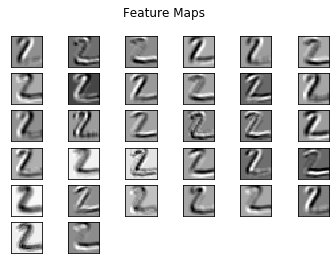

In [235]:
image_num = np.random.randint(0, X_test.shape[0])
image_array = X_test[1][0]
find_similiar_images(image_array)
